# Classification using pretrained, well-known models
This notebook aims to create a set of benchmarks for the project, using well-known, thoroughly studied models.
Either with pretrained weights, or training with new data.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
import master_data_functions.functions as dfunc

# silence deprecation warnings from tensorflow
import warnings
warnings.simplefilter('ignore', FutureWarning)

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples

keywords = {
    "single_1": "CeBr10kSingle_1",
    "single_2": "CeBr10kSingle_2",
    "mix": "CeBr10k_1",
    "small": "CeBr10"}
    
dataset = "mix"
data = dfunc.import_data("sample")
images = data[keywords[dataset]]["images"]
energies = data[keywords[dataset]]["energies"]
positions = data[keywords[dataset]]["positions"]
labels = to_categorical(data[keywords[dataset]]["labels"])
n_classes = labels.shape[1]


print("Number of classes: {}".format(n_classes))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))
      

/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

Number of classes: 2
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000, 2)


In [2]:
# VGG16 expects 3 channels. Solving this by concatenating the image data 
# to itself, to form three identical channels

images = np.concatenate((images, images, images), axis=3)

print("Image data shape: {}".format(images.shape))

Image data shape: (10000, 16, 16, 3)


## VGG-16 feature extraction


In [3]:
from master_models.pretrained import vgg_model
vgg = vgg_model()
vgg.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                  2

In [4]:
# Extract features with vgg
vgg_features = vgg.predict(images)

## Classification with custom dense network
### Build dense model

In [5]:
# Train a fully-connected network to classify based on
# extracted features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(4096, input_shape=vgg_features.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194      
Total params: 33,570,818
Trainable params: 33,570,818
Non-trainable params: 0
_________________________________________________________________


### Set up training and test data

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(vgg_features, labels, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

Training and test data shapes:
x_train: (8000, 4096)
x_test: (2000, 4096)
y_train: (8000, 2)
y_test: (2000, 2)


In [7]:
# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=128,
    validation_data=(x_test, y_test))

W0820 17:12:30.792028 140069331093312 deprecation.py:323] From /home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 28s 3ms/sample - loss: 7.6347 - accuracy: 0.5035 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 2/10
8000/8000 [==============================] - 34s 4ms/sample - loss: 7.6780 - accuracy: 0.5008 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 3/10
8000/8000 [==============================] - 29s 4ms/sample - loss: 7.6780 - accuracy: 0.5008 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 4/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 7.6780 - accuracy: 0.5008 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 5/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 7.6780 - accuracy: 0.5008 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 6/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 7.6780 - accuracy: 0.5008 - val_loss: 7.7511 - val_accuracy: 0.4960
Epoch 7/10
8000/8000 [==============================] - 25s 3ms/sample

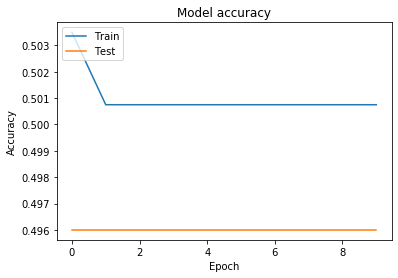

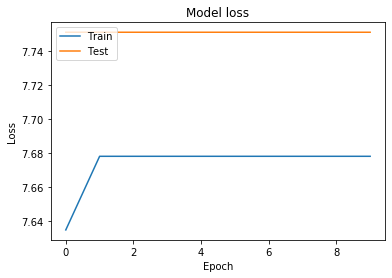

In [8]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# Check predictions
predicted = model.predict(x_test)
print(len(predicted[np.where(predicted[:,1] == 1.0)]))

2000
